In [1]:
!nvidia-smi

Wed Mar  6 11:06:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
! pip install -q bitsandbytes diffusers==0.25.1 transformers accelerate datasets wandb gdown
! pip install -q xformers==0.0.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
!pip show diffusers

Name: diffusers
Version: 0.25.1
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: patrick@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 


In [3]:
import os
import json
import accelerate
import wandb
import random
from datasets import Dataset, load_dataset, Features, Value
from PIL import Image
import numpy as np
import cv2
import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, DataCollatorWithPadding#, AutoImageProcessor, UperNetForSemanticSegmentation

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
!gdown 1nL1U_UirQTKfjMO-Sk90kLhWBo1LYG2N  # image_captions.json
!gdown 1-12WtQ6HfJVNL4xCe3ZDMuwVCLxUj4N7  # interior_verse_subset.zip
# !gdown 1Imqc0XrkBChJ4z31MpwGF8eoz--Oge_9  # interiorverse120.zip
# !gdown 1-0SE_XOj8DmTQF4YbeMKwPSyuWIc198S  # interiorverse80.zip
!gdown 1MbLcq3dLoT-_-8X2MzS3_M7eVpco8yRh # val_images_interio120.zip
!unzip -q '/content/interior_verse_subset.zip' -d '/content'
!unzip -q '/content/val_images_interio120.zip' -d '/content'

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1nL1U_UirQTKfjMO-Sk90kLhWBo1LYG2N

but Gdown can't. Please check connections and permissions.
Downloading...
From (original): https://drive.google.com/uc?id=1-12WtQ6HfJVNL4xCe3ZDMuwVCLxUj4N7
From (redirected): https://drive.google.com/uc?id=1-12WtQ6HfJVNL4xCe3ZDMuwVCLxUj4N7&confirm=t&uuid=0a2a4e64-99e6-4773-9c98-fa7afe662bd2
To: /content/interior_verse_subset.zip
100% 45.2M/45.2M [00:00<00:00, 95.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MbLcq3dLoT-_-8X2MzS3_M7eVpco8yRh
To: /content/val_images_interio120.zip
100% 708k/708k [00:00<00:00, 132MB/s]
replace /content/exr_subset/120/L3D187S21ENDIMGPXCQUI5NFSLUF3P3WY888_011_im.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### Logic to fine-tune inpainting

In [2]:
!rm -rf '/content/interior_design_challenge_022024/'

In [10]:
!git clone https://github.com/anilbhatt1/interior_design_challenge_022024.git

Cloning into 'interior_design_challenge_022024'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 652 (delta 91), reused 138 (delta 67), pack-reused 490
Receiving objects: 100% (652/652), 35.38 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [12]:
os.chdir('/content/interior_design_challenge_022024/terrain-diffusion-interior/scripts')
print(os.getcwd())
!ls

/content/interior_design_challenge_022024/terrain-diffusion-interior/scripts
build_text2rgb_captions.py  download_depth_dataset.py  train_text_to_image_lora_sd2_inpaint.py
build_text2rgb_dataset.py   download_rgb_dataset.py
captions_text2rgb.txt	    fix_text2rgb_dataset.py


In [13]:
!accelerate launch train_text_to_image_lora_sd2_inpaint.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting" \
  --dataset_name="custom" \
  --caption_column="text" \
  --mask_mode="512train-very-large" \
  --mixed_precision="fp16" \
  --train_batch_size=12 \
  --gradient_accumulation_steps=4 \
  --num_train_epochs=10 \
  --checkpointing_steps=40 \
  --learning_rate=1e-06 \
  --lr_scheduler="constant" \
  --seed=0 \
  --validation_epochs=5 \
  --validation_file="/content/val_images_interio120/validation.jsonl"\
  --output_dir="output" \
  --enable_xformers_memory_efficient_attention \
  --report_to="wandb" \
  --caption_file_path='/content/image_captions.json' \
  --val_image_dir='/content/val_images_interio120/'

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-03-06 11:14:32.952184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attem

#### Inferencing using LORA weights

In [5]:
!gdown 1Z-XW2JCLVgpjmfjqlNx0ZJNz7gUC3_2y

Downloading...
From: https://drive.google.com/uc?id=1Z-XW2JCLVgpjmfjqlNx0ZJNz7gUC3_2y
To: /content/terraindiff_sd15_lora_weights_0306_1702pm.safetensors
100% 3.23M/3.23M [00:00<00:00, 247MB/s]


In [6]:
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-inpainting", subfolder="unet")
print(f'unet done')
unet.requires_grad_(False)
weight_dtype = torch.float16
unet.to('cuda', dtype=weight_dtype)

unet done


UNet2DConditionModel(
  (conv_in): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

In [7]:
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    # print(f'name in unet : {name}')
    cross_attention_dim = (
        None
        if name.endswith("attn1.processor")
        else unet.config.cross_attention_dim
    )
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=4,
    )

In [8]:
unet.set_attn_processor(lora_attn_procs)

In [9]:
lora_layers = AttnProcsLayers(unet.attn_processors)

In [10]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=weight_dtype,
)
pipeline = pipeline.to('cuda')

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
unet_weight_path = '/content/terraindiff_sd15_lora_weights_0306_1702pm.safetensors'
pipeline.unet.load_attn_procs(unet_weight_path, use_safetensors=True)

In [12]:
val_dir = '/content/val_images_interio120'
print(f'val_dir : {val_dir}')
val_examples = []
with open('/content/val_images_interio120/validation.jsonl', "r") as val_index_fp:
    for line in val_index_fp:
        val_examples.append(json.loads(line))
print(f'val_examples : {val_examples}')

val_dir : /content/val_images_interio120
val_examples : [{'file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg', 'text': 'the room is a large, well - lit living room with a modern design. it features a variety of furniture, including a couch, a chair, and a dining table.'}, {'file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg', 'mask_file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_mask.jpg', 'text': 'the room is a bedroom with a large closet or wardrobe. the closet is made of wood and has a mirrored surface. the room also features a window, which allows natural light to enter the space.'}, {'file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_mask.jpg', 'text': 'the room is a large, open, and clean living room with a white color scheme. it features a couch, a chair, and a dining table.'}, {'

In [13]:
# run inference
generator = torch.Generator(device='cuda')
generator = generator.manual_seed(0)
images = []
for val_example in val_examples:
    val_image_path = os.path.join(val_dir, val_example["file_name"])
    print(f'val_image_path : {val_image_path}')
    val_image = Image.open(val_image_path).resize((512, 512))
    mask_image = (
        Image.open(os.path.join(val_dir, val_example["mask_file_name"]))
        .convert("L")
        .resize((512, 512))
    )
    images.append(
        pipeline(
            prompt=val_example["text"],
            image=val_image,
            mask_image=mask_image,
            num_inference_steps=30,
            strength=1.0,
            generator=generator,
        ).images[0]
    )

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S8ENDIMKV3ZYUI5NGMLUF3P3XA888_014_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFYDYQUI5L7ELUF3P3WW888_018_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMKT5UIUI5NYALUF3P3WS888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMO4UIYUI5NYALUF3P3XO888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMLVMJQUI5L7ELUF3P3WQ888_002_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDRF4BIUI5L7GLUF3P3XI888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

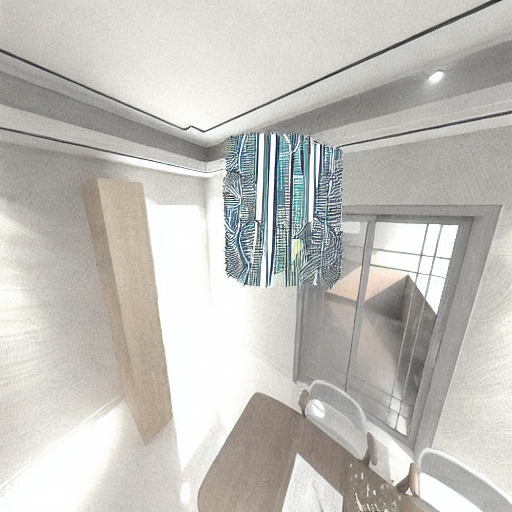

In [17]:
img_o = images[4]
img_o

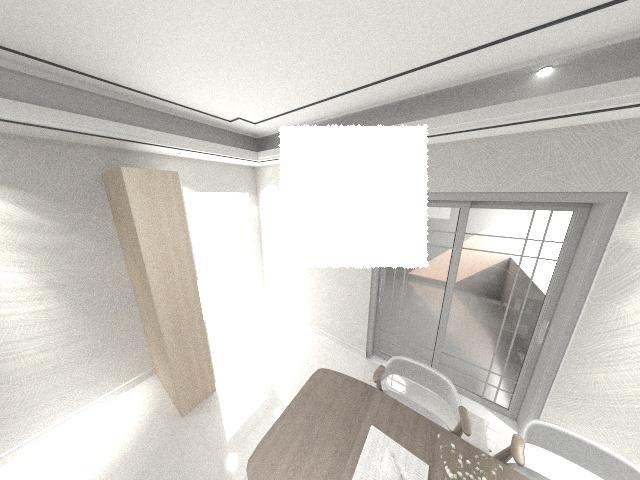

In [18]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFYDYQUI5L7ELUF3P3WW888_018_im_ip_mask.jpg')

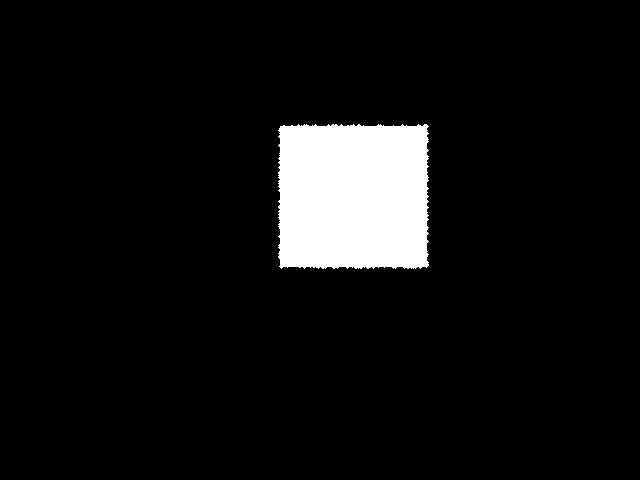

In [19]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFYDYQUI5L7ELUF3P3WW888_018_im_mask.jpg')